# The Impacts of Population on Air Quality Index (AQI)
* The goal of this section is to highlight trends pertaining to the effect of population on air quality. This was done by examining the relationship between US Census data and US EPA Annual AQI Summarys.
* This is important because AQI is a popular tool for measuring pollutants; the higher the air quality, the more toxins/pollutants that are present in the air.
* There is also a known correlation between prolonged exposure to poor quality air and lung disease.

In [1]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from datetime import datetime
from scipy import stats
from config import us_state_abbrevl, us_state_abbrevu, state_codes
import matplotlib.pyplot as plt
py.init_notebook_mode(connected=True)

## Data Cleaning
* To prep the data for plotting, the data was read into three separate dataframes and then cleaned to yield 2 common columns between all three data sets; "County" and "State Code (FIPS)".
* Once all data sets had the common columns they were then merged.

In [2]:
county_pop = pd.read_csv("raw_data/county_populations_census_2010-17.csv", encoding='latin-1')
county_pop = county_pop.rename(columns = {'April 1, 2010 - Census': '2010 Census',
                                          'April 1, 2010 - Estimates Base': 'Estimate Base',
                                          'Population Estimate (as of July 1) - 2010': '2010 Estimate',
                                          'Population Estimate (as of July 1) - 2011': '2011 Estimate',
                                          'Population Estimate (as of July 1) - 2012': '2012 Estimate',
                                          'Population Estimate (as of July 1) - 2013': '2013 Estimate',
                                          'Population Estimate (as of July 1) - 2014': '2014 Estimate',
                                          'Population Estimate (as of July 1) - 2015': '2015 Estimate',
                                          'Population Estimate (as of July 1) - 2016': '2016 Estimate',
                                          'Population Estimate (as of July 1) - 2017': '2017 Estimate'})
county_pop["County"] = county_pop['Geography'].apply(lambda x: x.split(", ")[0].lower())
county_pop["County"] = county_pop["County"].apply(lambda x: x.replace(" county", ""))
county_pop["County"] = county_pop["County"].apply(lambda x: x.replace(" parish", ""))
county_pop["State"] = county_pop['Geography'].apply(lambda x: x.split(", ")[-1])
county_pop = county_pop.replace({"State": us_state_abbrevu})
county_pop = county_pop.replace({"State": state_codes})
county_pop = county_pop.rename(columns = {"State": "State Code (FIPS)"})

In [3]:
air_quality = pd.read_csv("raw_data/county_aqi_1980_2018.csv")
air_quality = air_quality.drop(columns = 'Unnamed: 0')
air_quality['County'] = air_quality['County'].apply(lambda x: x.lower())
air_quality = air_quality.replace({"State": us_state_abbrevl})
air_quality = air_quality.replace({"State": state_codes})
air_quality = air_quality.rename(columns = {"State": "State Code (FIPS)"})

In [4]:
fips_17 = pd.read_excel("raw_data/all-geocodes-v2017.xlsx", skiprows = 4)
fips_17 = fips_17 [fips_17 ['Area Name (including legal/statistical area description)'].str.contains("County|Parish")]
fips_17 = fips_17[["State Code (FIPS)", "County Code (FIPS)",'Area Name (including legal/statistical area description)']]
fips_17['State Code (FIPS)'] = fips_17['State Code (FIPS)'].apply(lambda x: str(x).zfill(2))
fips_17['County Code (FIPS)'] = fips_17['County Code (FIPS)'].apply(lambda x: str(x).zfill(3))
fips_17['FIPS'] = fips_17['State Code (FIPS)'] + fips_17['County Code (FIPS)']
fips_17 = fips_17.rename(columns = {'Area Name (including legal/statistical area description)' : "County"})
fips_17["County"] = fips_17['County'].apply(lambda x: x.split(",")[0].lower())
fips_17["County"] = fips_17["County"].apply(lambda x: x.replace(" county", ""))
fips_17["County"] = fips_17["County"].apply(lambda x: x.replace(" parish", ""))

In [5]:
merged_data = pd.merge(left = fips_17,right = air_quality, how='left', on=['County', 'State Code (FIPS)'])
merged_data_nonan = merged_data [np.isfinite(merged_data['Max AQI'])]
merged_data_nonan.head(10)

,State Code (FIPS),County Code (FIPS),County,FIPS_x,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,...,State Abbreviation,FIPS_y,State FIPS Code,County FIPS Code,% Days Good,% Days Moderate,% Days Unhealthy for Sensitive Groups,% Days Unhealthy,% Days Very Unhealthy,% Days Hazardous
0,01,001,autauga,01001,1980.0,179.0,122.0,35.0,18.0,4.0,...,AL,1001.0,1.0,1.0,68.156425,19.553073,10.055866,2.234637,0.000000,0.0
1,01,001,autauga,01001,1981.0,357.0,289.0,49.0,15.0,4.0,...,AL,1001.0,1.0,1.0,80.952381,13.725490,4.201681,1.120448,0.000000,0.0
2,01,001,autauga,01001,1982.0,245.0,203.0,36.0,5.0,0.0,...,AL,1001.0,1.0,1.0,82.857143,14.693878,2.040816,0.000000,0.408163,0.0
3,01,001,autauga,01001,1989.0,63.0,54.0,9.0,0.0,0.0,...,AL,1001.0,1.0,1.0,85.714286,14.285714,0.000000,0.000000,0.000000,0.0
4,01,001,autauga,01001,1990.0,266.0,183.0,64.0,18.0,1.0,...,AL,1001.0,1.0,1.0,68.796992,24.060150,6.766917,0.375940,0.000000,0.0
5,01,003,baldwin,01003,2000.0,257.0,111.0,96.0,39.0,10.0,...,AL,1003.0,1.0,3.0,43.190661,37.354086,15.175097,3.891051,0.389105,0.0
6,01,003,baldwin,01003,2001.0,283.0,190.0,79.0,12.0,2.0,...,AL,1003.0,1.0,3.0,67.137809,27.915194,4.240283,0.706714,0.000000,0.0
7,01,003,baldwin,01003,2002.0,278.0,207.0,67.0,4.0,0.0,...,AL,1003.0,1.0,3.0,74.460432,24.100719,1.438849,0.000000,0.000000,0.0
8,01,003,baldwin,01003,2003.0,278.0,189.0,77.0,11.0,1.0,...,AL,1003.0,1.0,3.0,67.985612,27.697842,3.956835,0.359712,0.000000,0.0
9,01,003,baldwin,01003,2004.0,271.0,182.0,74.0,15.0,0.0,...,AL,1003.0,1.0,3.0,67.158672,27.306273,5.535055,0.000000,0.000000,0.0


## Gathering Metrics
* The metrics used to examine trends are the percentages of different air quality levels over the observation days.
* These metrics are gathered, along with additional metrics for other potential trends in order to plot by year.

In [6]:
df2010 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2010]
df2010 = pd.merge(left = df2010, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2010 = df2010["2010 Estimate"].apply(int)
good_days2010 = df2010["% Days Good"].apply(int)
unhealthy_days2010 = df2010["% Days Unhealthy"].apply(int)
unhealthys_days2010 = df2010["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2010 = df2010["% Days Moderate"].apply(int)
hazard_days2010 = df2010["% Days Hazardous"].apply(int)
max_aqi2010 = df2010["Max AQI"].apply(int)

df2011 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2011]
df2011 = pd.merge(left = df2011, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2011 = df2011["2011 Estimate"].apply(int)
good_days2011 = df2011["% Days Good"].apply(int)
unhealthy_days2011 = df2011["% Days Unhealthy"].apply(int)
unhealthys_days2011 = df2011["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2011 = df2011["% Days Moderate"].apply(int)
hazard_days2011 = df2011["% Days Hazardous"].apply(int)
max_aqi2011 = df2011["Max AQI"].apply(int)

df2012 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2012]
df2012 = pd.merge(left = df2012, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2012 = df2012["2012 Estimate"]
good_days2012 = df2012["% Days Good"]
unhealthy_days2012 = df2012["% Days Unhealthy"].apply(int)
unhealthys_days2012 = df2012["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2012 = df2012["% Days Moderate"].apply(int)
hazard_days2012 = df2012["% Days Hazardous"].apply(int)
max_aqi2012 = df2012["Max AQI"].apply(int)

df2013 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2013]
df2013 = pd.merge(left = df2013, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2013 = df2013["2013 Estimate"].apply(int)
good_days2013 = df2013["% Days Good"].apply(int)
unhealthy_days2013 = df2013["% Days Unhealthy"].apply(int)
unhealthys_days2013 = df2013["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2013 = df2013["% Days Moderate"].apply(int)
hazard_days2013 = df2013["% Days Hazardous"].apply(int)
max_aqi2013 = df2013["Max AQI"].apply(int)

df2014 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2014]
df2014 = pd.merge(left = df2014, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2014 = df2014["2014 Estimate"].apply(int)
good_days2014 = df2014["% Days Good"].apply(int)
unhealthy_days2014 = df2014["% Days Unhealthy"].apply(int)
unhealthys_days2014 = df2014["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2014 = df2014["% Days Moderate"].apply(int)
hazard_days2014 = df2014["% Days Hazardous"].apply(int)
max_aqi2014 = df2014["Max AQI"].apply(int)

df2015 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2015]
df2015 = pd.merge(left = df2015, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2015 = df2015["2015 Estimate"].apply(int)
good_days2015 = df2015["% Days Good"].apply(int)
unhealthy_days2015 = df2015["% Days Unhealthy"].apply(int)
unhealthys_days2015 = df2015["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2015 = df2015["% Days Moderate"].apply(int)
hazard_days2015 = df2015["% Days Hazardous"].apply(int)
max_aqi2015 = df2015["Max AQI"].apply(int)

df2016 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2016]
df2016 = pd.merge(left = df2016, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2016 = df2016["2016 Estimate"].apply(int)
good_days2016 = df2016["% Days Good"].apply(int)
unhealthy_days2016 = df2016["% Days Unhealthy"].apply(int)
unhealthys_days2016 = df2016["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2016 = df2016["% Days Moderate"].apply(int)
hazard_days2016 = df2016["% Days Hazardous"].apply(int)
max_aqi2016 = df2016["Max AQI"].apply(int)

df2017 = merged_data_nonan.loc[merged_data_nonan['Year'] == 2017]
df2017 = pd.merge(left = df2017, right = county_pop, how='left', on=['County', 'State Code (FIPS)'])
county_pops2017 = df2017["2017 Estimate"].apply(int)
good_days2017 = df2017["% Days Good"].apply(int)
unhealthy_days2017 = df2017["% Days Unhealthy"].apply(int)
unhealthys_days2017 = df2017["% Days Unhealthy for Sensitive Groups"].apply(int)
moderate_days2017 = df2017["% Days Moderate"].apply(int)
hazard_days2017 = df2017["% Days Hazardous"].apply(int)
max_aqi2017 = df2017["Max AQI"].apply(int)

## Plotting The Data
* Upon observation of the data, there are clear trends relating to population and AQI. As we can see from the trendlines, larger counties are less likely to have days where their AQI is considered Good.
* In addition to this, we see a trend between Moderate Days and Population where as population increases, so too does the likelihood that a county will have more days with a moderate AQI.

The mean r^2 value is: 0.17256468569137845


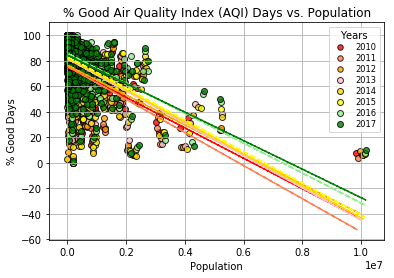

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/good_days_percent.png'

In [7]:
r = []
plt.scatter(county_pops2010, 
            good_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, good_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, good_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            good_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, good_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, good_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            good_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, good_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, good_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            good_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, good_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, good_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            good_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, good_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, good_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            good_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, good_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, good_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            good_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, good_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, good_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            good_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, good_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, good_days2017)
r.append(r_value*r_value)

plt.title("% Good Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Good Days")
plt.xlabel("Population")

plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
plt.savefig("Figures/good_days_percent.png")

In [ ]:
r = []
plt.scatter(county_pops2010, 
            moderate_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, moderate_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, moderate_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            moderate_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, moderate_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, moderate_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            moderate_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, moderate_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, moderate_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            moderate_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, moderate_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, moderate_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            moderate_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, moderate_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, moderate_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            moderate_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, moderate_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, moderate_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            moderate_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, moderate_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, moderate_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            moderate_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, moderate_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, moderate_days2017)
r.append(r_value*r_value)

plt.title("% Moderate Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Moderate Days")
plt.xlabel("Population")

plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
plt.savefig("Figures/moderate_days_percent.png")

In [ ]:
r = []
plt.scatter(county_pops2010, 
            unhealthys_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, unhealthys_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, unhealthys_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            unhealthys_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, unhealthys_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, unhealthys_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            unhealthys_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, unhealthys_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, unhealthys_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            unhealthys_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, unhealthys_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, unhealthys_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            unhealthys_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, unhealthys_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, unhealthys_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            unhealthys_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, unhealthys_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, unhealthys_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            unhealthys_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, unhealthys_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, unhealthys_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            unhealthys_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, unhealthys_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, unhealthys_days2017)
r.append(r_value*r_value)

plt.title("% Unhealthy for Sensitive Groups Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Unhealthy for Sensitive Groups Days")
plt.xlabel("Population")
plt.ylim(0,100)
plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
plt.savefig("Figures/unhealthys_days_percent.png")

In [ ]:
r = []
plt.scatter(county_pops2010, 
            unhealthy_days2010, 
            c="red", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2010")
z = np.polyfit(county_pops2010, unhealthy_days2010, 1)
p = np.poly1d(z)
plt.plot(county_pops2010,p(county_pops2010), color = "red", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2010, unhealthy_days2010)
r.append(r_value*r_value)

plt.scatter(county_pops2011, 
            unhealthy_days2011, 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2011")
z = np.polyfit(county_pops2011, unhealthy_days2011, 1)
p = np.poly1d(z)
plt.plot(county_pops2011,p(county_pops2011), color = "coral", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2011, unhealthy_days2011)
r.append(r_value*r_value)

plt.scatter(county_pops2012, 
            unhealthy_days2012,
            c="orange", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2012")
z = np.polyfit(county_pops2012, unhealthy_days2012, 1)
p = np.poly1d(z)
plt.plot(county_pops2012,p(county_pops2012), color = "orange", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2012, unhealthy_days2012)
r.append(r_value*r_value)

plt.scatter(county_pops2013, 
            unhealthy_days2013, 
            c="pink", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2013")
z = np.polyfit(county_pops2013, unhealthy_days2013, 1)
p = np.poly1d(z)
plt.plot(county_pops2013,p(county_pops2013), color = "pink", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2013, unhealthy_days2013)
r.append(r_value*r_value)

plt.scatter(county_pops2014, 
            unhealthy_days2014,
            c="gold", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2014")
z = np.polyfit(county_pops2014, unhealthy_days2014, 1)
p = np.poly1d(z)
plt.plot(county_pops2014,p(county_pops2014), color = "gold", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2014, unhealthy_days2014)
r.append(r_value*r_value)

plt.scatter(county_pops2015, 
            unhealthy_days2015,
            c="yellow", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2015")
z = np.polyfit(county_pops2015, unhealthy_days2015, 1)
p = np.poly1d(z)
plt.plot(county_pops2015,p(county_pops2015), color = "yellow", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2015, unhealthy_days2015)
r.append(r_value*r_value)

plt.scatter(county_pops2016, 
            unhealthy_days2016, 
            c="lightgreen", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2016")
z = np.polyfit(county_pops2016, unhealthy_days2016, 1)
p = np.poly1d(z)
plt.plot(county_pops2016,p(county_pops2016), color = "lightgreen", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2016, unhealthy_days2016)
r.append(r_value*r_value)

plt.scatter(county_pops2017, 
            unhealthy_days2017,
            c="green", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="2017")
z = np.polyfit(county_pops2017, unhealthy_days2017, 1)
p = np.poly1d(z)
plt.plot(county_pops2017,p(county_pops2017), color = "green", linestyle = "--")
slope, intercept, r_value, p_value, std_err = stats.linregress(county_pops2017, unhealthy_days2017)
r.append(r_value*r_value)

plt.title("% Unhealthy Air Quality Index (AQI) Days vs. Population")
plt.ylabel("% Unhealthy Days")
plt.xlabel("Population")
plt.ylim(0,80)
plt.grid(True)

lgnd = plt.legend(fontsize="small", mode="Expanded", 
                  numpoints=1, scatterpoints=1, 
                  loc="upper right", title="Years", 
                  labelspacing=0.25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]


avgr = np.mean(r)
print(f"The mean r^2 value is: {avgr}")
plt.show()
plt.savefig("Figures/unhealthy_days_percent.png")

## The State of our Air:
* Here is the most recent data we could find on AQI by county.
* Interesting points to look at would be Californian counties, simply because the state is notorious for its environmental laws.
    * This could be explained by the recent fires in the SoCal region.

In [ ]:
air = merged_data_nonan.loc[merged_data_nonan['Year'] == 2017]
lg = "#b3ffb3"
green = "#00cc00"
yellow = "#ffff00"
org = "#ff6600"
red = "#ff0000"
purp = "#990099"
maroon = "#660033"

colorscale = [lg,green,yellow,org,red,purp, maroon,
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]
endpts = [0, 50, 100, 150, 200, 300]
fips = air['FIPS_x'].tolist()
values = air['Median AQI'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='USA by Median Air Quality Index (AQI) [2017]',
    legend_title='AQI level'
)
py.iplot(fig, filename='median_aqi_usa17')